<a href="https://colab.research.google.com/github/hyulianton/JaringanSyarafTiruan/blob/main/jst_%F0%9F%92%BB_PyTorch_MLP_Training_dengan_Regularisasi_(MNIST).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 💻 PyTorch MLP Training dengan Regularisasi (MNIST)

### Cell 1: Setup dan Import Library ⚙️

Mengimpor *library* PyTorch yang diperlukan dan menetapkan *seed* untuk memastikan hasil yang **reproduktif** (penting untuk penelitian).

In [1]:
# ==============================================================================
# JST Sederhana (MLP) dengan Regularisasi L2
# Dataset: MNIST (Klasifikasi Multi-Kelas)
# Framework: PyTorch
# ==============================================================================

# Import Library yang diperlukan
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

# Tetapkan seed untuk reproduktifitas eksperimen
torch.manual_seed(42)
print("Library berhasil diimpor dan seed telah ditetapkan.")

Library berhasil diimpor dan seed telah ditetapkan.


### Cell 2: Konfigurasi Hyperparameter dan Perangkat

Menetapkan *hyperparameter* kunci, termasuk **Weight Decay** (Regularisasi L2), dan menentukan perangkat (GPU/CPU) untuk komputasi.

In [2]:
# Konfigurasi Hyperparameter
BATCH_SIZE = 128    # Mini-Batch Size: porsi data untuk satu kali update bobot
NUM_EPOCHS = 25     # Jumlah siklus penuh melalui seluruh dataset
LEARNING_RATE = 0.01# Laju Pembelajaran (ukuran langkah Gradient Descent)
WEIGHT_DECAY = 1e-4 # Regularisasi L2 (Penalti pada bobot besar)
NUM_CLASSES = 10    # Jumlah kelas MNIST (0-9)
INPUT_SIZE = 28 * 28 # Ukuran gambar (784 piksel)

# Tentukan perangkat (GPU jika tersedia, jika tidak CPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan perangkat: {DEVICE}")
print(f"Hyperparameter dikonfigurasi. WEIGHT_DECAY (L2) = {WEIGHT_DECAY}")

Menggunakan perangkat: cuda
Hyperparameter dikonfigurasi. WEIGHT_DECAY (L2) = 0.0001


### Cell 3: Memuat dan Mempersiapkan Data 💾

Memuat **MNIST**, menerapkan **Transformasi** wajib (Tensor dan Normalisasi), dan membagi data pelatihan menjadi **Training Set** dan **Validation Set** untuk memantau **Overfitting**.

In [3]:
# Definisikan transformasi
transform = transforms.Compose([
    transforms.ToTensor(),
    # Normalisasi standar untuk MNIST
    transforms.Normalize((0.1307,), (0.3081,))
])

# Memuat dataset MNIST
full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Memisahkan Dataset Pelatihan menjadi Training (90%) dan Validation (10%)
# Ini adalah siklus yang ketat untuk menguji generalisasi selama pelatihan
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

print(f"Dataset Pelatihan: {len(train_dataset)}, Dataset Validasi: {len(val_dataset)}, Dataset Testing: {len(test_dataset)}")

# Membuat DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print("DataLoader untuk Training, Validation, dan Testing berhasil dibuat.")

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 498kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.62MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.5MB/s]

Dataset Pelatihan: 54000, Dataset Validasi: 6000, Dataset Testing: 10000
DataLoader untuk Training, Validation, dan Testing berhasil dibuat.


### Cell 4: Mendefinisikan Arsitektur MLP dan Optimizer

Mendefinisikan arsitektur MLP. **Perhatian:** Regularisasi L2 diimplementasikan melalui parameter `weight_decay` pada *Optimizer*.

In [4]:
# JST (Multi-Layer Perceptron / MLP)
class SimpleMLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleMLP, self).__init__()
        # 3 Lapisan Linear dengan aktivasi ReLU
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Flatten input (28x28) menjadi vektor 784
        x = x.view(-1, INPUT_SIZE)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Inisialisasi model
model = SimpleMLP(INPUT_SIZE, NUM_CLASSES).to(DEVICE)

# Loss Function: Cross Entropy Loss (Klasifikasi Multi-Kelas)
criterion = nn.CrossEntropyLoss()

# Optimizer: Adam, mengimplementasikan Regularisasi L2 via 'weight_decay'
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

print("Arsitektur Model, Loss Function, dan Optimizer telah ditetapkan.")

Arsitektur Model, Loss Function, dan Optimizer telah ditetapkan.


### Cell 5: Siklus Pelatihan dan Validasi (Main Loop) 🚀

Menjalankan proses *Training* dan *Validation* untuk setiap *Epoch*. Ini adalah bagian krusial untuk memantau kinerja model dan efek **Regularisasi L2** pada **Validation Loss**.

In [5]:
# Fungsi pembantu untuk menghitung akurasi
def calculate_accuracy(loader, model):
    model.eval() # Mode evaluasi (penting: menonaktifkan mekanisme training seperti Dropout)
    correct = 0
    total = 0
    with torch.no_grad(): # Nonaktifkan perhitungan gradien untuk efisiensi
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# List untuk menyimpan sejarah Loss dan Akurasi
train_losses = []
val_losses = []
val_accuracies = []

print("Memulai Siklus Pelatihan dan Validasi...")
for epoch in range(NUM_EPOCHS):
    model.train() # Mode pelatihan
    running_loss = 0.0

    # --- TRAINING PHASE ---
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()   # 1. Reset gradien dari iterasi sebelumnya

        outputs = model(images) # 2. Forward pass
        loss = criterion(outputs, labels) # 3. Hitung Loss (termasuk penalti L2)

        loss.backward()         # 4. Backward pass (hitung gradien)
        optimizer.step()        # 5. Update Bobot (Langkah GD dengan penalti L2)

        running_loss += loss.item() * images.size(0)

    train_loss = running_loss / len(train_dataset)
    train_losses.append(train_loss)

    # --- VALIDATION PHASE ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_dataset)
    val_losses.append(val_loss)

    # Hitung Akurasi Validasi
    val_acc = calculate_accuracy(val_loader, model)
    val_accuracies.append(val_acc)

    # Cetak status setiap epoch
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}] '
          f'| Training Loss: {train_loss:.4f} '
          f'| Validation Loss: {val_loss:.4f} '
          f'| Validation Accuracy: {val_acc:.2f}%')

print("Pelatihan Selesai!")

Memulai Siklus Pelatihan dan Validasi...
Epoch [1/25] | Training Loss: 0.3076 | Validation Loss: 0.1907 | Validation Accuracy: 94.80%
Epoch [2/25] | Training Loss: 0.1669 | Validation Loss: 0.1845 | Validation Accuracy: 95.28%
Epoch [3/25] | Training Loss: 0.1508 | Validation Loss: 0.2063 | Validation Accuracy: 94.47%
Epoch [4/25] | Training Loss: 0.1476 | Validation Loss: 0.1729 | Validation Accuracy: 95.23%
Epoch [5/25] | Training Loss: 0.1472 | Validation Loss: 0.1905 | Validation Accuracy: 95.17%
Epoch [6/25] | Training Loss: 0.1443 | Validation Loss: 0.1827 | Validation Accuracy: 95.83%
Epoch [7/25] | Training Loss: 0.1363 | Validation Loss: 0.1963 | Validation Accuracy: 95.23%
Epoch [8/25] | Training Loss: 0.1426 | Validation Loss: 0.1441 | Validation Accuracy: 95.90%
Epoch [9/25] | Training Loss: 0.1329 | Validation Loss: 0.2240 | Validation Accuracy: 94.80%
Epoch [10/25] | Training Loss: 0.1344 | Validation Loss: 0.1508 | Validation Accuracy: 96.03%
Epoch [11/25] | Training Los

### Cell 6: Visualisasi Kurva Konvergensi 📊

Memvisualisasikan *Loss* dan *Akurasi* untuk menganalisis efek **Regularisasi L2** dalam menyeimbangkan **Training Loss** dan **Validation Loss**.

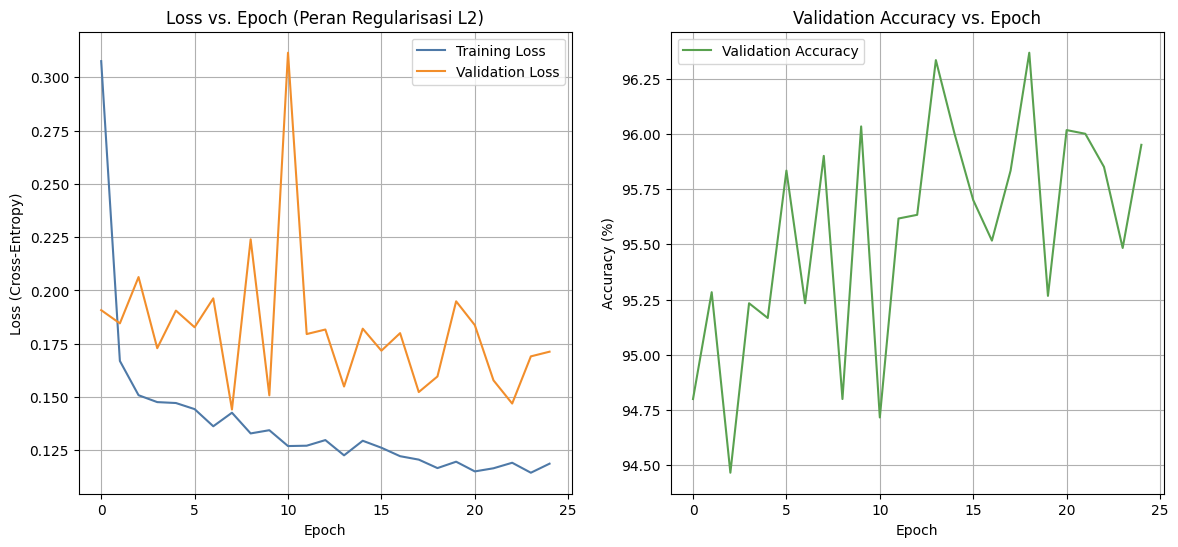

In [6]:
plt.figure(figsize=(14, 6))

# Plot Loss (Memeriksa Overfitting)
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='#4e79a7')
plt.plot(val_losses, label='Validation Loss', color='#f28e2b')
plt.title('Loss vs. Epoch (Peran Regularisasi L2)')
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross-Entropy)')
plt.legend()
plt.grid(True)

# Plot Akurasi Validasi
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='#59a14f')
plt.title('Validation Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.show()

### Cell 7: Siklus Testing (Evaluasi Akhir) ✅

Fase **Testing** yang dilakukan **sekali** pada **Test Set** untuk mendapatkan estimasi **Generalisasi** yang objektif.

In [7]:
# Memastikan model dalam mode evaluasi
model.eval()

print("\nMemulai Siklus Testing (Evaluasi Akhir)...")
# Hitung akurasi pada data testing
final_test_accuracy = calculate_accuracy(test_loader, model)

print(f'======================================================')
print(f'Akurasi Akhir pada Dataset Testing (Generalisasi): {final_test_accuracy:.2f}%')
print(f'======================================================')

# Catatan: Akurasi Testing adalah metrik yang seharusnya dilaporkan dalam riset Anda
# untuk menunjukkan seberapa baik model bergeneralisasi pada data baru.


Memulai Siklus Testing (Evaluasi Akhir)...
Akurasi Akhir pada Dataset Testing (Generalisasi): 96.29%
